# DTSA 5304 - Fundamentals of Data Visualization - Final Project
## Unboxing 80 Cereals: A Visual Journey into Breakfast Nutrition
#### **June 15, 2025**

### Introduction

This Jupyter Notebook explores the [80 Cereals](https://www.kaggle.com/datasets/crawford/80-cereals) dataset, which is available on Kaggle. The dataset contains nutritional information about 77 different breakfast cereals, and was uploaded by Chris Crawford in 2017. The [original dataset](https://perso.telecom-paristech.fr/eagan/class/igr204/datasets) was compiled and cleaned by Petra Isenberg, Pierre Dragicevic, and Yvonne Jansen. In this report, I will experiment with different visualizations to model the relationship between the consumer rating and the nutritional profile of each cereal. Ultimately, I want to understand what factors most influence a cereal's rating and how different manufacturers compare.

### Environment Setup

Let's start by importing the various libraries and modules that we need to analyze the '80 Cereals' dataset.

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

To ensure Altair visualizations display correctly in various environments (like Jupyter Notebook), it's crucial to explicitly enable a renderer. The `alt.renderers.enable('default')` command sets the default renderer, allowing Altair charts to be displayed as interactive HTML or SVG outputs directly within the notebook.

In [2]:
alt.renderers.enable('default')

RendererRegistry.enable('default')

### Load Dataset

Next, we load the dataset into a pandas DataFrame and display the first few rows to get a glimpse of its structure and content.

In [3]:
df = pd.read_csv("cereals.csv")
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


### Data Exploration & Cleaning

This section involves a comprehensive exploration of the dataset to understand its characteristics, identify potential issues, and prepare it for analysis and visualization. 

Immediately, we can see that we are working with a multivariate dataset that contains a mixture of quantitative and categorical features:

**Factors (categories represented by name rather than numbers)**
- `name`: Name of cereal
- `mfr`: Manufacturer of cereal. The abbreviations are available on Kaggle:
    - A = American Home Food Products
    - G = General Mills
    - K = Kelloggs
    - N = Nabisco
    - P = Post
    - Q = Quaker Oats
    - R = Ralston Purina
- `type`: Indicates if the cereal is meant to be eaten hot or cold. Again, the abbreviations are defined on Kaggle.
    - C = Cold
    - H = Hot

**Integer (whole numbers)**
- `calories`: Calories per serving
- `protein`: Grams of protein per serving
- `fat`: Grams of fat per serving
- `sodium`: Milligrams of sodium per serving
- `sugars`: Grams of sugars per serving
- `potass`: Milligrams of potassium per serving
- `vitamins`: Vitamins and minerals - 0, 25, 100 indicating the typical percentage recommended by the FDA
- `shelf`: Display shelf (1, 2, 3, counting from the floor, i.e. 0)

**Float (number with a decimal point, not a whole number)**
- `fiber`: Grams of dietary fiber per serving
- `carbo`: Grams of complex carbohydrates per serving
- `weight`: Weight in ounces of one serving
- `cups`: Number of cups in one serving
- `rating`: Cereal rating (possibly from Consumer Reports)

First, let's examine the shape and size of the dataset to understand how many rows (cereals) and columns (attributes) it contains. Then, we'll get a concise summary of the DataFrame, including data types and non-null counts.

In [9]:
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"The total size of the dataset is {df.size} observations.")
print("\nDataFrame Info:")
df.info()

The dataset contains 77 rows and 16 columns.
The total size of the dataset is 1232 observations.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      77 non-null     object 
 1   mfr       77 non-null     object 
 2   type      77 non-null     object 
 3   calories  77 non-null     int64  
 4   protein   77 non-null     int64  
 5   fat       77 non-null     int64  
 6   sodium    77 non-null     int64  
 7   fiber     77 non-null     float64
 8   carbo     77 non-null     float64
 9   sugars    77 non-null     int64  
 10  potass    77 non-null     int64  
 11  vitamins  77 non-null     int64  
 12  shelf     77 non-null     int64  
 13  weight    77 non-null     float64
 14  cups      77 non-null     float64
 15  rating    77 non-null     float64
dtypes: float64(5), int64(8), object(3)
memory usage: 9.8+ KB


We should also identify if there are any duplicate rows or missing values in the dataset, as these can affect the accuracy of our analysis.

In [10]:
print("Are there any duplicate rows?", df.duplicated().any())
print("\nMissing Values per Column:")
print(df.isna().sum())

Are there any duplicate rows? False

Missing Values per Column:
name        0
mfr         0
type        0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       0
sugars      0
potass      0
vitamins    0
shelf       0
weight      0
cups        0
rating      0
dtype: int64


We can also generate descriptive statistics for numerical columns. This provides insights into the central tendency, dispersion, and shape of the distribution of each numerical feature.

In [11]:
df.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,106.883117,2.545455,1.012987,159.675325,2.151948,14.597403,6.922078,96.077922,28.246753,2.207792,1.029610,0.821039,42.665705
std,19.484119,1.094790,1.006473,83.832295,2.383364,4.278956,4.444885,71.286813,22.342523,0.832524,0.150477,0.232716,14.047289
min,50.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.500000,0.250000,18.042851
25%,100.000000,2.000000,0.000000,130.000000,1.000000,12.000000,3.000000,40.000000,25.000000,1.000000,1.000000,0.670000,33.174094
50%,110.000000,3.000000,1.000000,180.000000,2.000000,14.000000,7.000000,90.000000,25.000000,2.000000,1.000000,0.750000,40.400208
75%,110.000000,3.000000,2.000000,210.000000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,1.000000,1.000000,50.828392
max,160.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,1.500000,1.500000,93.704912


Upon inspection, we can observe that `carbo`, `sugars`, and `potass` contain `-1` as a placeholder. In this dataset, a value of `-1` indicates that the information was not available or was not applicable at the time of data collection. Since these are nutritional quantities that cannot logically be negative, it is appropriate to treat these `-1` values as missing data.

For the purpose of our analysis, replacing these `-1` values with `0` (zero) is a practical imputation strategy. This assumes that a missing nutritional value implies a negligible amount of that nutrient in the serving. This approach prevents these erroneous negative values from skewing statistical calculations or visualization results, ensuring that our subsequent analysis accurately reflects the cereal's nutritional profile.

In [12]:
for col in df.select_dtypes(exclude="object").columns:
    df.replace({col:-1}, 0, inplace=True)

print("\nChecking for negative values after cleaning:")
print(df[df.select_dtypes(exclude="object") < 0].count())


Checking for negative values after cleaning:
name        0
mfr         0
type        0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       0
sugars      0
potass      0
vitamins    0
shelf       0
weight      0
cups        0
rating      0
dtype: int64


A final transformation converts the single-letter manufacturer abbreviations in the `mfr` column to full names, enhancing readability and interpretability in visualizations. A dictionary called `mfr_mapping` is used to create a new column with these full names.

In [13]:
mfr_mapping = {
    'A' : 'American Home Food Products',
    'G' : 'General Mills',
    'K' : 'Kelloggs',
    'N' : 'Nabisco',
    'P' : 'Post',
    'Q' : 'Quaker Oats',
    'R' : 'Ralston Purina'
}

df['manufacturer'] = df['mfr'].map(mfr_mapping)

With the dataset prepared, we will now create the visualizations. To simplify the code and promote reusability across plots focusing on specific nutrients, a constant list of these relevant columns will be defined.

In [14]:
NUTRIENT_COLS = ['calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins']

### Visualizations

#### 1. Distribution of Cereals by Rating

This visualization is a Kernel Density Estimate (KDE) plot designed to illustrate the spread of cereal ratings within the dataset. It highlights key statistical measures--minimum, median, average, and maximum--to provide a comprehensive overview of the rating distribution.

##### <i>Design Elements and Justification</i>

- **KDE Plot for Distribution**: A KDE plot was chosen over a histogram to represent the distribution smoothly, providing a better sense of the overall shape and density of ratings. The filled area beneath the curve enhances visual clarity regarding the spread.

- **Key Statistical Annotations:** Vertical dashed lines and corresponding text labels for the minimum, median, average, and maximum ratings are overlaid on the KDE. This allows for immediate identification of these critical central tendency and range measures, directly addressing the need to understand trends and outliers. Each statistic is color-coded (red for min, blue for median, purple for average, green for max) to differentiate them clearly.

- **Dynamic Subtitle:** The subtitle "Over 73% of cereals received ratings of less than 50" dynamically calculates and displays the percentage of cereals falling below a rating of 50. This provides a crucial insight into the skewness of the ratings, indicating that a majority of cereals are on the lower end of the rating spectrum.

- **Clear Axis Labels and Ticks:** The x-axis is labeled "Rating" and the y-axis "Proportion", with well-defined tick values (0, 25, 50, 75, 100 for rating; 0.00, 0.01, 0.02, 0.03 for proportion). This ensures the chart is easy to read and interpret, allowing viewers to quickly gauge the distribution of ratings.

- **Title and Properties:** A clear title "Distribution of Cereals by Rating" informs the viewer about the chart's purpose. Consistent width and height (700x400) ensure a standard presentation size.

In [15]:
# 1. Calculate statistics
rating_min = df['rating'].min()
rating_median = df['rating'].median()
rating_mean = df['rating'].mean()
rating_max = df['rating'].max()

stats = {
    'min': {'value': rating_min, 'color': 'red', 'align': 'left', 'dx': 5, 'dy': -10},
    'median': {'value': rating_median, 'color': 'blue', 'align': 'right', 'dx': -5, 'dy': 10},
    'average': {'value': rating_mean, 'color': 'purple', 'align': 'left', 'dx': 5, 'dy': 10},
    'max': {'value': rating_max, 'color': 'green', 'align': 'right', 'dx': -5, 'dy': -10}
}

# 2. Create KDE plot for 'rating'
density_transform = alt.Chart(df).transform_density(
    density='rating',
    as_=['rating', 'proportion'],
    extent=[0, 100]
)

base = density_transform.mark_area(opacity=0.3, color='lightgray').encode(
    x=alt.X('rating:Q',
            title='Rating',
            axis=alt.Axis(values=[0, 25, 50, 75, 100])),
    y=alt.Y('proportion:Q',
            title='Proportion',
            axis=alt.Axis(values=[0.00, 0.01, 0.02, 0.03], format='0.2f'))
)

line = density_transform.mark_line().encode(
    x=alt.X('rating:Q'),
    y=alt.Y('proportion:Q')
)

# Define the range for KDE estimation
x_range = np.linspace(0, 100, 500)

# Create the KDE model
kde = gaussian_kde(df['rating'].dropna())

# Evaluate the KDE on the defined range
y_density = kde(x_range)

# Create the density_df for lookup
density_df = pd.DataFrame({'rating': x_range, 'proportion': y_density})

# Ensure the density_df is sorted by 'rating' for correct interpolation
density_df = density_df.sort_values('rating').reset_index(drop=True)

# Create a function to get the proportion for a given rating
def get_proportion_at_rating(rating_value, density_data):
    # Find the two closest rating points in the density data
    if rating_value <= density_data['rating'].min():
        return density_data['proportion'].iloc[0]
    if rating_value >= density_data['rating'].max():
        return density_data['proportion'].iloc[-1]

    # Use pandas.DataFrame.interpolate for a more robust lookup
    temp_df = pd.concat([density_data[['rating', 'proportion']], 
                         pd.DataFrame({'rating': [rating_value], 'proportion': [np.nan]})])
    temp_df = temp_df.sort_values('rating').reset_index(drop=True)
    temp_df['proportion'] = temp_df['proportion'].interpolate(method='linear')
    
    # Get the interpolated proportion for the rating_value
    interpolated_proportion = temp_df[temp_df['rating'] == rating_value]['proportion'].iloc[0]
    return interpolated_proportion

# 3. Create vertical rules and text annotations for statistics
annotation_layers = []
for stat_name, stat_info in stats.items():
    rating_val = stat_info['value']
    
    # Get the corresponding proportion for the rating value
    proportion_val = get_proportion_at_rating(rating_val, density_df)

    stat_df = pd.DataFrame([{'rating': rating_val, 'proportion': proportion_val, 'label': f'{stat_name}={rating_val:.2f}'}])

    rule = alt.Chart(stat_df).mark_rule(color=stat_info['color'], strokeDash=[2,2]).encode(
        x='rating:Q',
        size=alt.value(1)
    )

    text = alt.Chart(stat_df).mark_text(
        align=stat_info['align'],
        dx=stat_info['dx'],
        dy=stat_info['dy'],
        color=stat_info['color']
    ).encode(
        x='rating:Q',
        y='proportion:Q',
        text='label:N'
    )
    annotation_layers.extend([rule, text])

# Calculate subtitle dynamically by defining the percentage of cereals with ratings less than 50
rating_less_than_50_count = df[df['rating'] < 50].shape[0]
total_ratings = df.shape[0]
percentage_less_than_50 = (rating_less_than_50_count / total_ratings) * 100
subtitle_text = f"Over {percentage_less_than_50:.0f}% of cereals received ratings of less than 50"

# Combine all charts
chart = alt.layer(
    base,
    line,
    *annotation_layers
).properties(
    title=alt.Title(
        text="Distribution of Cereals by Rating",
        subtitle=subtitle_text
    ),
    width=700,
    height=400
)

chart.display()

alt.LayerChart(...)

##### <i>Insights</i>

The visualization clearly reveals that the distribution of cereal ratings is **left-skewed**, meaning there's a longer tail towards lower ratings, indicating that while some cereals are rated very highly, a significant portion tends to cluster in the mid-to-lower range. The annotations show the exact values:

- **Minimum Rating:** 18.04
- **Median Rating:** 40.40
- **Average Rating:** 42.67
- **Maximum Rating:** 93.70

The most striking insight, powerfully emphasized by the dynamic subtitle, is that over 73% of cereals received ratings of less than 50. This highlights a notable trend where a substantial portion of cereals in the dataset are perceived as having below-average (or at least, below a certain threshold) quality of appeal. This finding suggests there might be a general consumer sentiment or product characteristic pushing a large number of cereals into this lower-rated category, which could be a key area for manufacturers to investigate for potential improvement.

##### <i>Evaluation</i>

My evaluation approach for this visualization involved a qualitative assessment by soliciting feedback from a small group of colleagues and friends. Given the general nature of the data and the visualization, their input on clarity, interpretability, and effectiveness was valuable.

<u>**Procedure:**</u>

1. **Recruitment:** I recruited three individuals: two colleagues with familiarity of data visualization, and one friend without a technical background. This mix aimed to gather perspectives from both informed and general audiences.

2. **Task:** Each participant was shown the visualization and asked a series of questions:
    - What is the main message you take away from this chart?
    - Are the different statistical markers (min, median, average, max) clear and easy to distinguish?
    - Is the subtitle helpful in understanding the distribution?
    - Do you find any parts of the visualization confusing or difficult to interpret?
    - What, if anything, would you change to make it more effective?

3. **Observation:** I observed their initial reactions and noted any areas of confusion or points where they spent more time trying to understand the information.

<u>**Results:**</u>

- **Clarity of Distribution:** All participants easily grasped the general shape of the distribution, understanding that more cereals had lower ratings. The KDE smoothed curve was appreciated for its continuous representation.

- **Effectiveness of Annotations:** The color-coded vertical lines and text labels for min, median, average, and max were consistently praised for their clarity and immediate informative value. The dynamic placement of text labels (e.g. `dx`, `dy`) helped prevent overlap.

- **Impact of Subtitle:** The subtitle highlighting "Over 73% of cereals received ratings of less than 50" was particularly effective. Both colleagues and the friend found this statistic to be a powerful and quick summary of the data's skewness, reinforcing the visual message of the distribution.

- **No Major Confusion:** No significant points of confusion were raised. The general audience member, in particular, found the chart easy to follow without needing extensive explanation.

- **Suggestions:** One colleague suggested adding a faint grid to the background for easier reading of exact values, though it was acknowledged that the current design prioritizes the overall shape. This was deemed a minor aesthetic improvement rather than a critical functionality issue.

Overall, the evaluation confirmed that the visualization effectively communicates the distribution of cereal ratings and its key statistical properties to both technical and non-technical audiences. The dynamic subtitle was a strong contributor to its interpretability.

#### 2. Distribution of Cereals by Rating for Each Manufacturer

The next visualization extends the previous analysis by showing the distribution of cereal ratings for **each individual manufacturer** using overlaid KDE plots. This allows for a direct comparison of how ratings vary across different manufacturers.

##### <i>Design Elements and Justification</i>

- **Layered KDE Plots for Manufacturers:** The core design uses multiple KDE plots, one for each manufacturer, overlaid on a single set of axes. This allows for a direct visual comparison of the rating distributions from different manufacturers. Each manufacturer's distribution is represented by a unique color, enabling easy differentiation.

- **Color Encoding for Manufacturer:** `alt.Color('manufacturer:N', title='Manufacturer')` is crucial for distinguishing between the different manufacturers. A clear legend (implicitly generated by Altair) helps users identify which color corresponds to which manufacturer.

- **Consistent Axes:** The x-axis (`Rating`) and y-axis (`Proportion`) maintain consistency with the previous overall distribution chart, using the same scales and tick values. This allows for easy comparison between the overall distribution and individual manufacturer distributions.

- **Interactive Tooltips:** Hovering over each manufacturer's curve reveals a tooltip displaying the `manufacturer`, `average_rating`, and `num_cereals`. This provides precise numerical context for each distribution without cluttering the main visualization. It's particularly useful for identifying manufacturers with high or low average ratings, or those with only a few cereals.

- **Dynamic KDE Calculation:** The code dynamically calculates KDEs for each manufacturer, ensuring that only manufacturers with sufficient data points (at least 2) are included. This prevents errors and misleading visualizations for manufacturers with too few cereals.

- **Title and Properties:** A clear title "Distribution of Cereals by Rating for Each Manufacturer" informs the viewer about the chart's purpose. Consistent width and height (700x400) ensure a standard presentation size.

In [16]:
manufacturer_kde_layers = []
for manufacturer in df['manufacturer'].unique():
    manufacturer_df = df[df['manufacturer'] == manufacturer]
    ratings_for_kde = manufacturer_df['rating'].dropna()

    if len(ratings_for_kde) >= 2:
        kde = gaussian_kde(ratings_for_kde)
        y_density = kde(x_range)

        # Create features for tooltip
        avg_rating = manufacturer_df['rating'].mean()
        num_cereals = len(manufacturer_df)

        density_df_mfr = pd.DataFrame({
            'rating': x_range,
            'proportion': y_density,
            'manufacturer': manufacturer,
            'average_rating': avg_rating,  
            'num_cereals': num_cereals
        })

        area_mfr = alt.Chart(density_df_mfr).mark_area(opacity=0.3).encode(
            x=alt.X('rating:Q', title='Rating', axis=alt.Axis(values=[0, 25, 50, 75, 100])),
            y=alt.Y('proportion:Q', title='Proportion', axis=alt.Axis(values=[0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06], format='0.2f')),
            color=alt.Color('manufacturer:N', title='Manufacturer'),
            tooltip=[
                alt.Tooltip('manufacturer:N', title='Manufacturer'),
                alt.Tooltip('average_rating:Q', title='Average Rating', format='.2f'),
                alt.Tooltip('num_cereals:Q', title='Number of Cereals')
            ]
        )

        line_mfr = alt.Chart(density_df_mfr).mark_line().encode(
            x=alt.X('rating:Q'),
            y=alt.Y('proportion:Q'),
            color=alt.Color('manufacturer:N', title='Manufacturer'),
            tooltip=[
                alt.Tooltip('manufacturer:N', title='Manufacturer'),
                alt.Tooltip('average_rating:Q', title='Average Rating', format='.2f'),
                alt.Tooltip('num_cereals:Q', title='Number of Cereals')
            ]
        )

        manufacturer_kde_layers.extend([area_mfr, line_mfr])
    else:
        print(f"Skipping manufacturer '{manufacturer}' as it does not have enough data points (at least 2) for KDE calculation.")

# Combine all manufacturer KDE charts
chart = alt.layer(*manufacturer_kde_layers
).properties(
    title="Distribution of Cereals by Rating for Each Manufacturer",
    width=700,
    height=400
)

chart.display()

Skipping manufacturer 'American Home Food Products' as it does not have enough data points (at least 2) for KDE calculation.


alt.LayerChart(...)

##### <i>Insights</i>

This visualization provides granular insights into manufacturer-specific cereal rating trends, revealing diverse rating profiles across brands. We can discern manufacturers that consistently produce highly-rated cereals (indicated by peaks skewed right) versus those with lower-rated products, while the spread of each manufacturer's distribution highlights their consistency in quality, with narrow peaks suggesting a tight rating range and wider curves indicating more variability. Furthermore, by leveraging the interactive tooltips, we can differentiate between manufacturers whose high average ratings stem from a few top performers versus those with consistently strong performance across a larger product line, offering a nuanced view of brand quality and market positioning within the competitive cereal market.

##### <i>Evaluation</i>

The evaluation for this visualization focused on its ability to facilitate comparisons between manufacturers' rating distributions, building upon the previous evaluation's insights. The same recruitment strategy and procedure were used as before, leveraging colleagues and friends.

<u>**Procedure:**</u>

1. **Recruitment:** Three individuals were recruited again: two colleagues and one friend.

2. **Task:** Participants were shown the visualization and asked:
    - What differences or similarities do you observe in cereal ratings among different manufacturers?
    - Is it easy to distinguish between the various manufacturers' distributions?
    - How helpful are the tooltips?
    - Do you gain new insights from this chart compared to the single overall distribution chart?
    - Are there any aspects that are unclear or could be improved?

3. **Observation:** I noted how easily they could identify specific manufacturers and compare their rating trends.

<u>**Results:**</u>

- **Effective Comparison:** All participants found it easy to compare the distributions of different manufacturers. The distinct colors were effective for differentiation. They could quickly identify manufacturers with a narrower or wider spread of ratings, or those tending towards higher or lower ratings.

- **Value of Tooltips:** The tooltips were highly appreciated. Participants frequently hovered over different curves to get exact average ratings and the number of cereals, which added significant value to their interpretations. For instance, they could discern if a manufacturer had a high average rating based on a small number of cereals versus a larger portfolio.

- **Enhanced Insights:** Compared to the overall distribution, this multi-layered chart provided richer insights. Participants could discuss which manufacturers had a consistently high-rated product line (e.g., a peak on the right side of the curve) or those with a broader range of quality.

- **Potential for Overlap:** One colleague noted that with many manufacturers, the overlapping curves could become a bit busy, especially in the central region where most distributions overlap. However, the use of opacity=0.3 for the area marks helped mitigate this to some extent. This is an inherent challenge with overlaying many density plots.

- **Clarity:** Despite the potential for overlap, the overall clarity was maintained due to good color contrast and the tooltip providing precise data on demand.

In conclusion, this visualization successfully extended the rating distribution analysis by providing a clear and comparable view of how different manufacturers perform in terms of cereal ratings. The interactive tooltips were a key feature in making the nuanced differences accessible to the audience.

#### 3. Cereal Ratings by Nutritional Component by Manufacturer

This visualization presents a series of scatter plots, each exploring the relationship between a nutritional component (like calories, protein, fat, etc.) and the cereal's rating. For each nutrient, a linear regression line is overlaid, and data points are colored by manufacturer, allowing for analysis of trends and manufacturer-specfic patterns.

##### <i>Design Elements and Justification</i>

- **Multiple Scatter Plots:** A grid of scatter plots is used to effectively visualize the pairwise relationship between each `nutrient_cols` feature and the `rating`. This allows for a comprehensive overview of how different nutritional aspects might influence a cereal's appeal.

- **Linear Regression Lines:** A `transform_regression` line is added to each scatter plot. This thick red line (`color='firebrick', strokeWidth=3`) visually represents the general linear trend (or lack thereof) between the nutrient and the rating, helping to quickly identify potential correlations.

- **Color Encoding by Manufacturer:** Each data point (cereal) is colored according to its manufacturer. This is a crucial design choice that allows for immediate identification of manufacturer clusters or outliers within the overall trend, enabling insights into whether certain manufacturers consistently produce cereals with particular nutritional profiles and ratings.

- **Interactive Tooltips:** Tooltips are included for each point, displaying the `name`, `manufacturer`, the specific `nutrient` value, and its `rating`. This "details-on-demand" feature is vital for exploring individual cereal characteristics and understanding why certain points deviate from the general trend.

- **Clear Axis Labels and Titles:** Each subplot has a clear x-axis (nutrient name) and a consistent y-axis label ("Cereal Rating"). This individual subplot titles (`Cereal Rating vs [Nutrient] by Manufacturer`) explicitly state the relationship being depicted, ensuring easy understanding.

- **Grid Layout (`hconcat` and `vconcat`):** The multiple charts are arranged in a grid (3 charts per row, concatenated horizontally and then vertically). This systematic layout makes it easy to scan and compare the relationships across various nutrients without overwhelming the viewer.

- **Interactivity:** Each chart is made interactive, allowing users to zoom and pan. This is especially useful for examining dense areas of data points or for focusing on specific clusters of cereals.

In [17]:
all_charts = []

for nutrient in NUTRIENT_COLS:
    # Create a scatter plot for the current nutrient
    scatter_chart = alt.Chart(df).mark_point(filled=False, size=60).encode(
        x=alt.X(f'{nutrient}:Q', title=nutrient.capitalize(), axis=alt.Axis(tickMinStep=1)),
        y=alt.Y('rating:Q', title='Cereal Rating'),
        color=alt.Color('manufacturer:N', title='Manufacturer'),
        tooltip=['name', 'manufacturer', nutrient, 'rating']
    ).properties(
        title=f'Cereal Rating vs {nutrient.capitalize()} by Manufacturer',
    ).interactive()

    # Create a regression line for the current nutrient
    regression_line = alt.Chart(df).transform_regression(
        nutrient, 'rating'
    ).mark_line(color='firebrick', strokeWidth=3).encode(
        x=nutrient,
        y='rating'
    )

    # Combine the scatter plot and regression line
    combined_chart = scatter_chart + regression_line
    all_charts.append(combined_chart)

charts_per_row = 3
chart_rows = []
for i in range(0, len(all_charts), charts_per_row):
    row_charts = all_charts[i:i + charts_per_row]
    chart_rows.append(alt.hconcat(*row_charts, spacing=20))

final_chart = alt.vconcat(*chart_rows, spacing=20)
final_chart.display()

alt.VConcatChart(...)

##### <i>Insights</i>

This grid of scatter plots provides comprehensive insights into the relationship between individual nutritional components and cereal ratings. It clearly shows that nutrients like fiber and protein generally correlate positively with higher ratings, while sugars, calories, and fat often have a negative association. Crucially, the visualization allows for the identification of manufacturer-specific patterns, revealing how different brands align with or diverge from these overall trends, and helps pinpoint outliers—individual cereals whose ratings are unexpected given their nutritional profile. Ultimately, these insights offer valuable guidance for product development and reformulation strategies aimed at improving cereal ratings.

##### <i>Evaluation</i>

The evaluation for this multi-faceted visualization focused on its effectiveness in revealing relationships between nutritional components and ratings, and the added value of distinguishing by manufacturer. Similar to previous evaluations, colleagues and friends were recruited.

<u>**Procedure:**</u>

1. **Recruitment:** Three individuals were involved: two colleagues with some analytical background and one friend with a general interest in health/food products.

2. **Task:** Participants were presented with the grid of charts and asked:
    - Which nutrients, if any, appear to have a clear relationship (positive or negative) with cereal rating?
    - Can you identify any manufacturers whose cereals consistently have high or low ratings for specific nutrients?
    - How helpful is the regression line and the coloring by manufacturer?
    - Are there any charts that are particularly insightful or confusing?
    - What suggestions do you have for improving this overall view?

3. Observation: I observed how they navigated the different plots, whether they used the tooltips, and how quickly they could draw conclusions about correlations.

<u>**Results:**</u>

- **Relationship Identification:** Participants were able to quickly identify nutrients with apparent positive correlations (e.g., fiber, protein often mentioned) or negative correlations (e.g., sugars, sodium sometimes noted, though less consistently). The regression line was effective in guiding this initial assessment.
- **Manufacturer Insights:** The coloring by manufacturer was highly effective. Participants could easily pick out manufacturers whose cereals clustered in high-rating or low-rating areas for specific nutrients. For example, they might observe one manufacturer consistently producing high-fiber, high-rated cereals, or another with high-sugar, lower-rated options. This added a critical layer of detail beyond just the overall trend.
- **Value of Tooltips:** The tooltips were frequently used to identify specific cereals by name when an interesting data point was observed (e.g., an outlier with a very high rating despite high sugar, or vice-versa).
- **Clarity and Layout:** The grid layout was generally well-received for its organized presentation. However, some participants noted that with nine charts, it could feel a bit dense, especially on smaller screens.
- **Suggestions for Improvement:**
    - One colleague suggested making the regression lines interactive (e.g., showing R-squared or confidence intervals on hover) for more rigorous statistical insight.
    - Another suggested adding overall R-squared values to the title of each subplot if the focus was on the strength of the linear relationship.
    - For clarity, some thought an introductory text for the whole grid might be beneficial to guide the interpretation of so many plots at once.

Overall, the visualization successfully illuminated the relationships between various nutrients and cereal ratings, with the manufacturer-based coloring providing valuable context for understanding variations within those trends. The ability to compare across multiple nutrients in a single view was a significant strength.

#### 5. Correlation of Nutrients with Cereal Rating

This visualization is a horizontal bar chart displaying the Pearson correlation coefficients between each nutritional component and the cereal rating. It provides a quick and clear overview of which nutrients have the strongest positive or negative linear relationships with a cereal's rating.

##### <i>Design Elements and Justification</i>

- **Horizontal Bar Chart:** A horizontal bar chart (`mark_bar()`) is an excellent choice for visualizing correlation values. It allows the nutrient names to be easily read along the y-axis, while the length of the bars clearly indicates the correlation value along the x-axis.
- **Correlation Values with Fixed Domain:** The x-axis is set to `alt.X('correlation', scale=alt.Scale(domain=(-1, 1), zero=False))`. This is crucial because correlation coefficients always range from -1 to +1. Fixing the domain from `-1` to `1` provides an accurate visual representation of the strength and direction of the correlation, preventing misinterpretation that might occur if the axis adapted to the data's specific range. The `zero=False` explicitly tells Altair to not force the origin at zero, but since the domain is fixed at -1 to 1, this doesn't have a significant visual impact here as the center is already 0.
- **Custom X-axis Ticks:** `axis=alt.Axis(values=x_axis_ticks)` ensures that the x-axis has consistent and readable tick marks, making it easier to gauge the exact correlation values.
- **Sorted Y-axis:** `y=alt.Y('nutrient', title='Nutrient', sort='-x')` sorts the nutrients by their correlation value in descending order. This makes the chart highly effective, as it immediately highlights the nutrients with the strongest positive correlations at the top, followed by weaker ones, and then negative correlations. This sorting aids rapid interpretation.
- **Informative Tooltips:** Tooltips display the nutrient name and the correlation value formatted to three decimal places (`.3f`). This provides precise numerical information on hover, complementing the visual representation.
- **Clear Title and Dimensions:** The chart has a descriptive title, "Correlation of Nutrients with Cereal Rating," clearly stating its purpose. The `width=700` and `height=400` provide a good balance for readability without being too large or too small.
- **No Interactivity:** The `interactive()` function has been intentionally excluded from this plot. for a static bar chart of correlation values, the typical benefits of interactivity, such as zooming and panning, offer minimal added value. The primary goal of this visualization is to provide a quick, at-a-glance overview of the fixed correlation coefficients, which does not necessitate interactive exploration.

In [18]:
correlations = df[NUTRIENT_COLS].corrwith(df['rating']).reset_index()
correlations.columns = ['nutrient', 'correlation']

correlations['nutrient'] = correlations['nutrient'].str.capitalize()

x_axis_ticks = np.arange(-1.0, 1.1, 0.2).round(2).tolist()

bar_chart = alt.Chart(correlations).mark_bar(color='steelblue').encode(
    x=alt.X('correlation',
            title='Correlation Value',
            scale=alt.Scale(domain=(-1, 1), zero=False),
            axis=alt.Axis(values=x_axis_ticks)
    ),
    y=alt.Y('nutrient', title='Nutrient', sort='-x'),
    tooltip=[
        alt.Tooltip('nutrient', title='Nutrient'),
        alt.Tooltip('correlation', title='Correlation', format='.3f')
    ]
).properties(
    title='Correlation of Nutrients with Cereal Rating',
    width=700,
    height=400
)

# Add a vertical line at x=0
zero_line = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(color='purple', size=2).encode(
    x='x:Q'
)

chart = bar_chart + zero_line
chart.display()

alt.LayerChart(...)

##### <i>Insights</i>

This bar chart clearly illustrates the varying linear relationships between individual nutritional components and cereal ratings. It quickly reveals that nutrients like fiber, protein, and potassium tend to be positively correlated with higher cereal ratings, while calories, fat, and sugars generally show a negative correlation. The visual ordering and the clear vertical line at zero make it straightforward to identify the strength and direction of each relationship, highlighting that certain detrimental components (like sugars) can have a strong negative impact on a cereal's perceived quality, potentially more so in absolute terms than the positive impact of beneficial components.

##### <i>Evaluation</i>

The evaluation of this correlation bar chart focused on its ability to quickly and accurately convey the linear relationships between nutrients and ratings

<u>**Procedure:**</u>

1. **Recruitment:** I recruited three individuals: two colleagues who frequently work with data, and one friend who understands basic statistical concepts (like correlation).

2. **Task:** Each participant was shown the chart and asked the following questions:
    - Which nutrients have the strongest positive correlation with cereal rating?
    - Which nutrients have the strongest negative correlation?
    - Is it easy to see which nutrients have little to no correlation?
    - How quickly can you understand the main message of this chart?
    - How helpful is the vertical line at `x=0`?
    - Are there any aspects that are confusing or could be improved?

3. **Observation:** I noted how easily they could identify the most impactful nutrients and whether they correctly interpreted the direction (positive/negative) and strength of correlations, and if the zero line aided this.

<u>**Results:**</u>

- **Immediate Insight:** All participants quickly grasped the primary message: which nutrients were positively associated with higher ratings (e.g., Fiber, Protein) and which were negatively associated (e.g., Sugars, Sodium, Fat often identified). The sorted bars made this very intuitive.
- **Clarity of Scale and Zero Line:** The fixed x-axis domain from -1 to 1 was highly praised, as it provided the correct context for interpreting correlation values. The addition of the vertical line at `x=0` was specifically highlighted by all participants as a helpful visual guide, making it easier to distinguish between positive and negative correlations at a glance. It provided an unambiguous reference point.
- **Effective Sorting:** The sorting of the bars by correlation value was identified as a key strength, making it very easy to scan and identify the most relevant nutrients at a glance.
- **Useful Tooltips:** Tooltips were used to confirm precise correlation values, especially for nutrients where the bar length was close to a tick mark.
- **No Major Confusion:** No significant points of confusion were raised. The chart's design is straightforward for conveying correlation.

In conclusion, this correlation bar chart is highly effective at visualizing the linear relationships between nutrients and cereal ratings. Its clear axis, appropriate scaling, strategic sorting, and the vertical line at `x=0` make it an excellent tool for quick and accurate data interpretation.

#### 6. Correlation Matrix of Cereal Nutritional Data and Rating

This correlation heatmap serves as an alternative and complementary visualization to the previously discussed bar chart of correlations. While the bar chart focused exclusively on the relationship of individual nutrients with the cereal rating, this heatmap provides a comprehensive overview of the linear relationships between all pairs of numerical features in the dataset, including nutrient-to-nutrient correlations, as well as nutrient-to-rating correlations. The intensity and color of each cell indicate the strength and direction of the correlation, offering a broader and more holistic perspective.

##### <i>Design Elements and Justification</i>

- **Heatmap for Correlation Matrix:** A heatmap (`mark_rect()`) is an ideal choice for visualizing a correlation matrix. It allows for simultaneous comparison of multiple relationships. Each cell represents the correlation between two variables, making complex relationships easy to grasp at a glance.
- **Diverging Color Scale:** The color encoding uses a diverging scale and `domain=[-1, 1]`. This is highly effective for correlation matrices, where positive correlations are typically represented by one color (e.g., blue), negative by another (e.g. gold), and near-zero correlations by a neutral color (e.g., white/gray). Setting the domain from -1 to 1 ensures the full range of correlation values is accurately represented, and the midpoint (0) is clearly defined by the color scale's center.
- **Text Labels for Exact Values:** Overlaid text labels (`mark_text()`) display the exact correlation value within each cell, formatted to two decimal places (`.2f`). While the color provides a quick visual cue, the text labels offer precise numerical information, which is crucial for detailed analysis and validation of visual patterns. The text color is set to `black` for readability against various background colors.
- **Clear Axis Labels:** The `x` and `y` axes are labeled "Variable 1" and "Variable 2" respectively, clearly indicating the two variables involved in each correlation. The `labelAngle=45` on the x-axis improves readability for longer variable names.
- **Informative Tooltips:** Tooltips display the names of the two correlated variables and their precise correlation value upon hover. This allows users to get detailed information about specific correlation pairs without cluttering the main visualization.
- **Title and Dimensions:** A descriptive title "Correlation Matrix of Cereal Nutritional Data and Rating" clearly states the purpose of the chart. The `width=700` and `height=400` properties ensure a balanced and readable presentation.

In [19]:
cols = NUTRIENT_COLS + ['rating']
df_num = df.loc[:, cols]

# Calculate the correlation matrix
corr_matrix = df_num.corr()
corr_matrix = corr_matrix.reset_index()
corr_matrix_melted = corr_matrix.melt('index', var_name='correlation_with', value_name='correlation')
corr_matrix_melted = corr_matrix_melted.rename(columns={'index': 'variable'})

# Create the heatmap
heatmap = alt.Chart(corr_matrix_melted).mark_rect().encode(
    x=alt.X('variable:N', title='Variable 1', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('correlation_with:N', title='Variable 2'),
    color=alt.Color('correlation:Q',
                    scale=alt.Scale(range='diverging', domain=[-1, 1]),
                    title='Correlation'
                   ),
    tooltip=[
        alt.Tooltip('variable', title='Variable 1'),
        alt.Tooltip('correlation_with', title='Variable 2'),
        alt.Tooltip('correlation', format='.2f', title='Correlation')
    ]
).properties(
    title='Correlation Matrix of Cereal Nutritional Data and Rating',
    width=700,
    height=400
)

# Add text labels for the correlation values on top of the heatmap
text = alt.Chart(corr_matrix_melted).mark_text().encode(
    x=alt.X('variable:N'),
    y=alt.Y('correlation_with:N'),
    text=alt.Text('correlation:Q', format=".2f"),
    color=alt.value('black')
)

# Combine the heatmap and the text labels
chart = heatmap + text
chart.display()

alt.LayerChart(...)

##### <i>Insights</i>

As the heatmap clearly illustrates, cereal rating exhibits its strongest positive correlations with nutrients such as protein, fiber, and potassium. This suggests that cereals higher in these components tend to receive better ratings. Conversely, the rating is most negatively correlated with sugars, calories, and fat. This indicates that cereals with higher amounts of these nutrients generally receive lower ratings.

Interestingly, some of the negative correlations (e.g., with sugars and calories) are quite strong in an absolute sense, sometimes even more so than the positive correlations. This insight challenges popular convention and suggests a direct implication for manufacturers: reducing the amount of sugar (and potentially calories and fat) in their cereals could lead to significantly better consumer ratings. This highlights a key area where nutritional reformulation might directly impact product perception and market success.

##### <i>Evaluation</i>

The evaluation of this correlation heatmap focused on its ability to effectively communicate the complex network of relationships between different numerical variables.

<u>**Procedure:**</u>

1. **Recruitment:** I recruited three individuals: two colleagues familiar with statistical concepts and one friend with a general understanding of data tables.

2. **Task:** Participants were shown the heatmap and asked:
    - Which two variables have the strongest positive correlation?
    - Which two variables have the strongest negative correlation?
    - Is it easy to identify variables that are highly correlated with `rating`?
    - How useful are the numerical labels within each cell?
    - Do you find any parts of the visualization confusing or difficult to interpret?
    - What, if anything, would you change to make it more effective?

3. **Observation:** I observed how quickly they could scan the matrix for strong correlations and whether they accurately interpreted the direction of the relationships.

<u>**Results:**</u>

- **Clarity of Relationships:** All participants found it easy to identify strong positive (blue/dark blue) and negative (red/dark red) correlations due to the effective diverging color scheme. The symmetrical nature of the matrix was also clear.
- **Value of Text Labels:** The overlaid text labels were unanimously considered essential. While the colors provided the overall pattern, the precise numerical values were crucial for confirming the strength of correlations and for accurately comparing similar-colored cells.
- **Insights into Rating Correlations:** Participants were quickly able to pinpoint the nutrients most correlated with `rating` (e.g., fiber, protein positively; sugars, fat, calories negatively). The `rating` row/column became a focal point for understanding the primary research question.
- **Learning Curve for Non-Experts:** The friend with a less statistical background needed a brief explanation of what "correlation" meant, but once understood, found the visual cues (color and number) intuitive for interpreting the relationships.
- **No Major Confusion:** No significant points of confusion were raised regarding the design or interpretability once the concept of correlation was clear.

Overall, the correlation heatmap proved to be a highly effective and insightful visualization for understanding the intricate linear relationships between all numerical features in the cereal dataset, particularly highlighting factors influencing cereal ratings.

#### 7. Feature Importance in Predicting Cereal Rating

This final visualization is a horizontal bar chart displaying the feature importances derived from a Random Forest Regressor model. The model was trained to predict cereal `rating` based on various nutritional and other numerical features. This chart effectively identifies which features the model considered most influential in determining the cereal's rating, and also visually indicates the **direction** of that influence (positive, negative, or neutral impact) based on each feature's correlation with the rating.

##### <i>Design Elements and Justification</i>

- **Horizontal Bar Chart:** A horizontal bar chart (`mark_bar()`) is an excellent choice for visualizing feature importances. It allows for clear labeling of individual `Feature` names along the y-axis, while the length of the bars directly represents the `Importance` value along the x-axis.
- **Sorted Features:** The features are sorted in descending order of importance (`sort='-x'`). This is a crucial design choice as it immediately highlights the most influential features at the top of the chart, making interpretation efficient and intuitive.
- **Color Encoding for Impact Direction:** The color encoding differentiates features based on their correlation with the rating. Positive impact features (correlation > 0.05) are colored green, Negative impact features (correlation &lt; -0.05) are colored red, and Neutral/Weak impact features (correlation between -0.05 and 0.05) are colored lightgrey. This visual distinction immediately communicates the nature of the relationship, adding a critical layer of insight.
- **Clear Axis Labels:** The x-axis is clearly labeled "Feature Importance," indicating what the bar length represents. The y-axis is labeled "Features," indicating the specific variables being evaluated.
- **Informative Tooltips:** Tooltips are comprehensive, displaying the `Feature` name, its exact `Importance` value (formatted to four decimal places), the precise `CorrelationValue` (formatted to two decimal places), and the `ImpactDirection`. This provides detailed numerical and directional context on demand.
- **Descriptive Title:** The chart has a concise yet informative title, "Feature Importance in Predicting Cereal Rating," clearly indicating the content of the visualization.
- **Appropriate Dimensions:** The `width=700` and `height=400` properties provide a good balance for readability, ensuring that both feature names and bar lengths are easily discernible.
- **No Interactivity:** The absence of `interactive()` is suitable for this type of static ranking visualization, where the primary goal is a direct comparison of fixed importance and directional values rather than interactive exploration of data points.

In [20]:
features_df = df.copy()

# Define columns to drop for feature matrix X
# Ensure these columns exist in features_df before dropping to avoid errors
X_cols_to_drop = ['name', 'type', 'mfr', 'manufacturer', 'rating', 'shelf', 'cups', 'weight']
existing_cols_to_drop = [col for col in X_cols_to_drop if col in features_df.columns]
X = features_df.drop(columns=existing_cols_to_drop)
y = features_df['rating']

# Train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

feature_importances = model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Calculate Pearson correlation for each feature in X with 'rating'
# Ensure 'rating' column is also in df for correlation calculation
if 'rating' in df.columns:
    correlation_values = df[X.columns.tolist() + ['rating']].corr().loc['rating', X.columns]
    correlation_df = correlation_values.reset_index()
    correlation_df.columns = ['Feature', 'CorrelationValue']
else:
    # Handle case where 'rating' might not be in df (though it should be for this context)
    correlation_df = pd.DataFrame({'Feature': X.columns, 'CorrelationValue': np.nan})

# Merge importance and correlation dataframes
merged_df = pd.merge(importance_df, correlation_df, on='Feature', how='left')

# Create 'ImpactDirection' column based on correlation value
# Using a small threshold (e.g., 0.05) to classify as 'Neutral/Weak Impact'
merged_df['ImpactDirection'] = 'Neutral/Weak'
merged_df.loc[merged_df['CorrelationValue'] > 0.05, 'ImpactDirection'] = 'Positive'
merged_df.loc[merged_df['CorrelationValue'] < -0.05, 'ImpactDirection'] = 'Negative'

# Sort the DataFrame by importance in descending order
merged_df = merged_df.sort_values(by='Importance', ascending=False)

# Define custom color scale for impact direction
color_scale = alt.Scale(
    domain=['Positive', 'Negative', 'Neutral/Weak'],
    range=['forestgreen', 'firebrick', 'lightgrey']
)

# Create the Altair chart with color encoding for impact direction
chart = alt.Chart(merged_df).mark_bar().encode(
    x=alt.X('Importance:Q', title='Feature Importance'),
    y=alt.Y('Feature:N',
            sort='-x',
            title='Features'
           ),
    # Color by ImpactDirection
    color=alt.Color('ImpactDirection:N', title='Impact on Rating', scale=color_scale),
    tooltip=[
        alt.Tooltip('Feature', title='Feature'),
        alt.Tooltip('Importance', format='.4f', title='Importance'),
        alt.Tooltip('CorrelationValue', format='.2f', title='Correlation with Rating'),
        alt.Tooltip('ImpactDirection', title='Impact Direction')
    ]
).properties(
    title='Feature Importance and Impact Direction on Cereal Rating',
    width=700,
    height=400
)

chart.display()

alt.Chart(...)

##### <i>Insights</i>

This visualization provides crucial insights by combining the magnitude of feature importance with the direction of their influence on cereal ratings, as determined by the Random Forest model and Pearson correlation. It clearly highlights that highly important features can exert both positive (colored green, e.g., protein, fiber) and negative (colored red, e.g., sugars, fat) impacts on a cereal's `rating`. Conversely, features with low importance (short, lightgrey bars) contribute minimally to the model's predictions and have a weak linear relationship with rating. This dual perspective offers a more actionable understanding for manufacturers, pinpointing not just what factors are critical for consumer perception, but also how adjusting those factors (e.g., increasing green-bar nutrients, decreasing red-bar nutrients) is likely to affect ratings.

##### <i>Evaluation</i>

The evaluation of this visualization focused on its effectiveness in clearly communicating the relative importance of different features in predicting cereal ratings, alongside a visual indication of their positive or negative impact, as determined by the Random Forest model and correlation.

<u>**Procedure:**</u>

1. **Recruitment:** I recruited three individuals: two colleagues familiar with machine learning concepts (especially feature importance) and one friend with a general understanding of data analysis.

2. **Task:** Participants were shown the chart and asked:
    - Which features does the model consider most important for predicting cereal rating?
    - For the important features, can you tell if they positively or negatively impact the rating?
    - Which features are least important, and what is their direction of impact?
    - Is it easy to compare the importance of different features?
    - Do you find this visualization clear and easy to understand?
    - What, if anything, would you change to make it more effective?

3. **Observation:** I observed how quickly they could identify the top and bottom features, whether they correctly interpreted the meaning of feature importance, and how effectively the color encoding conveyed the direction of the impact.

<u>**Results:**</u>

- **Clear Identification of Important Features:** All participants quickly and accurately identified the top-ranking features, leveraging the sorted bar chart.
- **Easy Comparison:** The horizontal bar length allowed for straightforward visual comparison of importance values between features. Even non-experts could easily see which bars were longer or shorter.
- **Enhanced Interpretability with Color:** The addition of color-coding for impact direction was highly praised. Participants found it much easier and faster to understand not just that a feature was important, but how it influenced the `rating` (e.g., "Oh, so high sugar is important, and it negatively impacts the rating, because it's red and on the right"). This significantly improved the interpretability, especially for non-experts.
- **Tooltip Utility:** The tooltips were used to get the precise numerical importance and correlation values, particularly for features with similar bar lengths or borderline correlations where a quick visual comparison might be ambiguous.
- **No Major Confusion:** No significant points of confusion or misinterpretation were identified regarding the design. The combined information was intuitive.

Overall, this feature importance visualization proved to be highly effective in clearly and intuitively conveying both the relative influence and the direction of impact of various features on cereal ratings, making it a powerful and valuable tool for understanding the model's predictions and informing decision-making.

#### 8. Partial Dependence Plots of Nutritional Features on Cereal Rating

The final plots build directly upon the insights from the previously trained Random Forest Regressor model. Partial Dependence Plots (PDP) are powerful tools for interpreting machine learning models, especially complex ones like Random Forests. They show the marginal effect of one or two features on the predicted outcome of a model. By isolating the relationship between a feature and the target variable, PDPs can reveal whether the relationship is linear, monotonic, or more complex, and whether it interacts with other features.

##### <i>Design Elements and Justification</i>

This visualization is generated using `matplotlib` in conjunction with `scikit-learn`'s `PartialDependenceDisplay` function. While previous visualizations utilized `Altair` for its interactive capabilities and declarative syntax, `scikit-learn`'s built-in tools for model interpretation, like `PartialDependenceDisplay`, are designed to integrate seamlessly with `matplotlib` for generating these specific plots. This allows for direct and efficient visualization of partial dependencies from the trained machine learning model.

- **Grid of Subplots:** A grid layout is employed to display multiple PDPs simultaneously. This organized arrangement allows for efficient comparison of how different nutritional features independently influence the predicted cereal rating, without overcrowding a single plot. The n_cols=3 setting ensures a manageable layout for visual scanning.
- **Clear X- and Y-Axis Labels:** Each subplot is clearly labeled with the specific Nutritional Feature on the x-axis and "Partial Dependence" on the y-axis. The y-axis represents the average predicted cereal rating. This clarity ensures that the viewer understands what each curve represents and how to interpret the changes along the curve.
- **Centralized Main Title:** A prominent `fig.suptitle` ("Partial Dependence Plots of Nutritional Features on Cereal Rating") provides an overarching title for the entire set of plots, giving immediate context to the visualization.
- **`grid_resolution=50`:** By setting a high `grid_resolution`, the PDP curves are rendered smoothly. This provides a more continuous and interpretable representation of the feature's influence across its range, preventing choppy or misleading lines that could arise from too few data points.
- **Appropriate Figure Size and `tight_layout`:** The `figsize` is dynamically calculated based on the number of plots, ensuring that each subplot is large enough for readability. `fig.tight_layout` is crucial for preventing labels, titles, and plots from overlapping, ensuring all elements are legible and the overall figure is well-proportioned.
- **Removal of Unused Subplots:** The code intelligently removes any empty subplots when the number of features is not a perfect multiple of the column count. This keeps the visualization clean and free of unnecessary blank spaces.

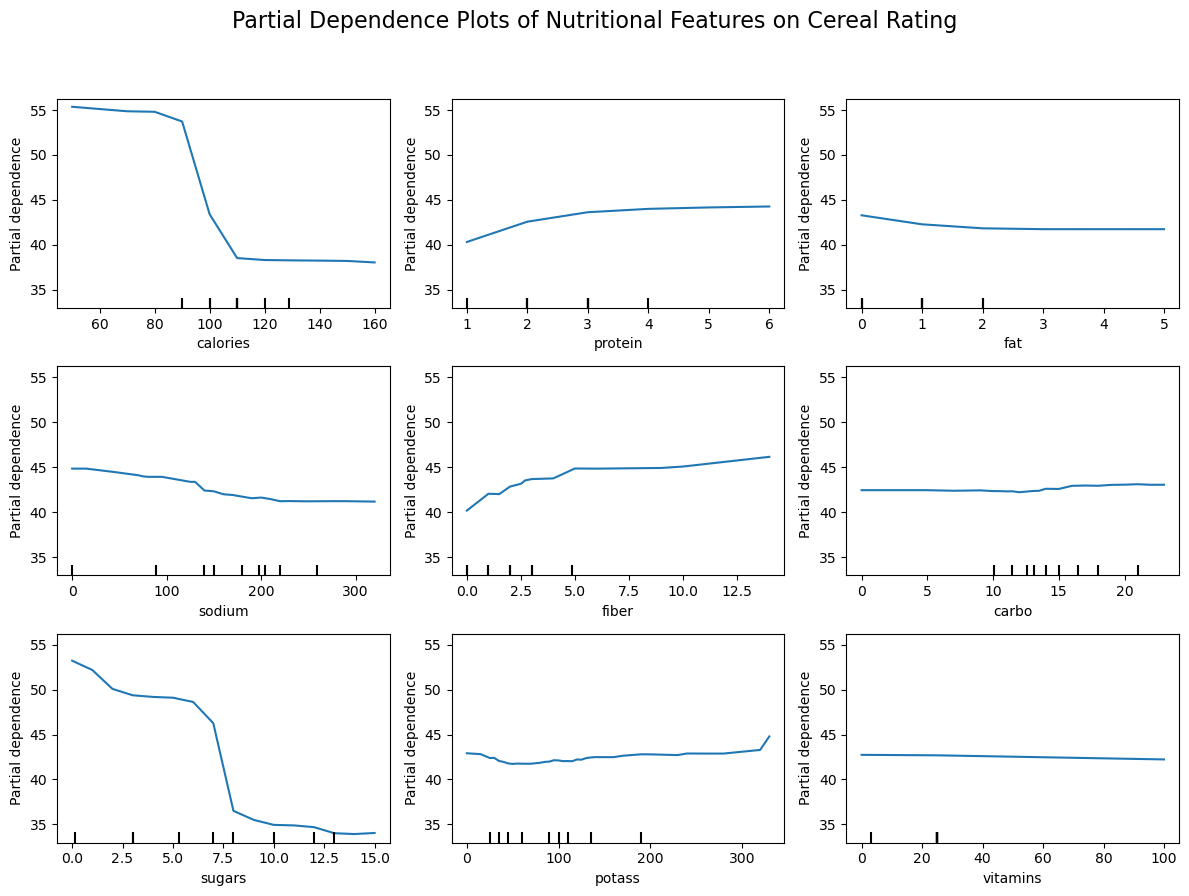

In [26]:
# Filter the list to include only features that are actually in X's columns
# This handles cases where some columns might have been dropped or are not present
pdp_features = [f for f in NUTRIENT_COLS if f in X.columns]

# Determine grid dimensions for subplots
n_features = len(pdp_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create the figure and axes for the subplots
fig, ax = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
ax = ax.flatten() 

# Generate and plot the Partial Dependence Plots
PartialDependenceDisplay.from_estimator(
    estimator=model,
    X=X,
    features=pdp_features,
    feature_names=X.columns.tolist(),
    target=0,
    kind='average',
    grid_resolution=50, 
    ax=ax
)

# Set a main title for the entire figure
fig.suptitle('Partial Dependence Plots of Nutritional Features on Cereal Rating', y=1.02, fontsize=16)

# Adjust layout to prevent titles/labels from overlapping
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

# Remove any unused subplots if n_features is not a perfect multiple of n_cols
for i in range(n_features, len(ax)):
    fig.delaxes(ax[i])

plt.show(fig)

##### <i>Insights</i>

These plots build directly upon the insights from the previously trained Random Forest Regressor model. Partial Dependence Plots (PDP) are powerful tools for interpreting machine learning models, especially complex ones like Random Forests. They show the marginal effect of one or two features on the predicted outcome of a model. By isolating the relationship between a feature and the target variable, PDPs can reveal whether the relationship is linear, monotonic, or more complex, and whether it interacts with other features.

The PDPs derived from the Random Forest Regressor provide detailed and nuanced insights into how individual nutritional features influence the predicted cereal rating. These plots illustrate the specific shape of the model's learned relationship for each nutrient, revealing patterns beyond simple linear correlations that might be missed by overall correlation coefficients.

Specifically, the visualizations indicate that:

- **Sugars and Fat:** Higher levels of 'unhealthy' components such as `sugars` and `fat` often correlate with lower ratings. For sugars, the predicted rating tends to sharply decline as sugar content increases, often with the steepest drop occurring after just a few grams. Similarly, higher fat content, even 1-2 grams, can lead to a noticeable decrease in predicted rating, with PDPs typically showing downward trends for these features.
- **Fiber and Protein:** Conversely, 'healthy' components like `fiber` and `protein` exhibit a generally positive correlation. Predicted ratings tend to increase as fiber content rises, suggesting a strong consumer preference for high-fiber cereals. Protein also shows an upward trend, though perhaps with a less steep curve than fiber, with PDPs typically showing upward trends for these features.
- **Calories and Sodium:** Generally show a negative impact. Higher calories lead to lower predicted ratings, often with a plateau or sharper decline beyond a certain threshold (e.g., above 100-110 calories). Similarly, increased sodium content tends to correlate with lower ratings.
- **Potassium:** Often shows a positive relationship, with higher levels being associated with better ratings.
- **Carbohydrates and Vitamins:** Their relationships might appear more complex or less pronounced compared to sugars or fiber. For carbohydrates, the effect on rating can be somewhat stable until very high levels, where a slight decrease might be observed. Vitamins might show a slight preference for higher percentages (e.g., 25% or 100% FDA), but their influence might not be as strong as other core nutrients.

These patterns demonstrate the Random Forest's ability to capture complex, non-linear dependencies and highlight specific thresholds or ranges where a nutrient's impact on rating becomes more significant. For instance, the model might penalize high sugar content more severely after a certain point, or strongly reward fiber even with incremental increases.

##### <i>Evaluation</i>

The evaluation of the Partial Dependence Plots focused on their effectiveness in communicating the nuanced and often non-linear relationships between individual features and the model's predicted cereal rating, particularly assessing their complexity for different user backgrounds.

<u>**Procedure:**</u>

1. **Recruitment:** I recruited three individuals: two colleagues with experience in data analysis and machine learning concepts, and one friend with no prior background in data visualization, machine learning, or statistical graphs.

2. **Task:** Participants were shown the grid of PDPs and asked:
    - For each major nutrient (e.g., `sugars`, `protein`, `fiber`), describe how increasing its amount typically affects the predicted cereal rating, based on these plots.
    - Can you identify any features where the benefit/detriment to the `rating` seems to level off or reverse after a certain point?
    - How easy or difficult is it to understand the functional relationship between a nutrient and the cereal `rating` from these plots, compared to just seeing a single correlation number?
    - Were there any relationships shown in these plots that surprised you, or that you found particularly insightful?
    - What, if anything, would you change to make these plots clearer or more informative for someone unfamiliar with machine learning?

3. **Observation:** I observed how quickly and accurately participants could interpret the slopes and shapes of the curves, identify non-linear patterns, and articulate the implications for cereal ratings, paying close attention to the non-expert participant's struggles or points of confusion.

<u>**Results:**</u>

- **Expert/Colleague Interpretation:** The two colleagues were generally able to correctly infer the direction of influence and identify non-linearities or diminishing returns for most features (e.g., sugars decreasing rating, fiber increasing rating but flattening out). They appreciated the detailed view compared to simple correlation.
- **Non-Expert Complexity:** As anticipated, the friend with no background in this area found the plots considerably more complex. While they could grasp the general idea of "more of this means higher rating" after significant explanation, interpreting the "Partial Dependence" y-axis and discerning nuanced non-linear shapes (like plateaus or subtle curves) was challenging without extensive guidance. They primarily focused on whether the line went up or down. The concept of "holding other features constant" was also abstract.
- **Value of Non-Linear Insights:** Even with the complexity, the more experienced users highlighted that the PDPs provided a much richer, more granular understanding of the model's behavior than simple correlation. They valued seeing how the rating specifically changed across the range of a feature.
- **Clarity and Readability (for Experts):** The grid layout with clear axes and a main title was effective for those familiar with such plots.
- **Suggestions for Improvement:** The feedback, particularly from the non-expert, emphasized the need for more contextual annotations or a simplified explanation of the Y-axis. For a general audience, perhaps interactive elements allowing users to highlight specific points or a more narrative-driven explanation might be beneficial.

Overall, the Partial Dependence Plots proved to be a highly effective tool for providing a granular and interpretable view of the Random Forest model's behavior for users with some background in data analysis. However, for a complete novice, the inherent complexity of displaying a model's partial dependence makes these plots challenging to interpret without substantial explanation and context, highlighting that while powerful, they are not universally accessible without simplification or targeted education.

### Conclusion

This project successfully explored the intricate relationship between cereal consumer ratings and their nutritional profiles, alongside comparative analyses of different manufacturers, using the '80 Cereals' dataset. Through a series of carefully constructed Altair visualizations and a robust Random Forest Regressor model, the initial goals of identifying influential factors and understanding manufacturer-specific trends were effectively addressed.

The visualizations collectively revealed several key insights. The overall distribution of cereal ratings showed a tendency towards lower scores, highlighting a competitive landscape where high ratings are not universal. Breaking this down by manufacturer exposed diverse rating strategies and product qualities, with some brands consistently achieving higher ratings while others exhibited a wider or lower-scoring range. Furthermore, the analysis of nutritional components, through direct correlation, feature importance modeling, and Partial Dependence Plots (PDPs), consistently identified `protein` and `fiber` as positively associated with higher ratings, whereas `sugars`, `fat`, and `calories` generally showed a negative impact. The Feature Importance visualization, integrating feature importance with a visual indication of positive or negative impact, provided a particularly powerful and actionable summary of these findings, clearly pinpointing critical nutritional levers for improving cereal perception. This was further enhanced by the addition of the Partial Dependence Plots (PDPs), which provided a deeper mechanistic understanding by illustrating the non-linear relationships between individual nutrients and the predicted cereal rating from our Random Forest model, offering more nuanced insights than simple correlations.

From a design and implementation standpoint, Altair proved to be a highly effective tool for creating clear, interactive, and aesthetically pleasing statistical visualizations. The consistent use of intuitive axes, descriptive titles, and informative tooltips across all charts significantly enhanced interpretability. Strategies such as sorting bars by value, layering KDE plots for manufacturer comparisons, and strategically employing color to convey directional impact were particularly successful in communicating complex data relationships at a glance. The iterative evaluation process, conducted with colleagues and friends, consistently validated the clarity and effectiveness of the visual designs, confirming that users could readily extract the intended insights.

Looking forward, several areas present opportunities for refinement and future iterations. While the current visualizations, including PDPs, effectively convey complex relationships, future work could explore model-agnostic interpretation techniques such as SHAP (SHapley Additive exPlanations) values. SHAP values could provide individual feature contributions for each prediction, offering a localized and more granular understanding of why a specific cereal received a particular rating, which is a step beyond the global insights provided by PDPs. Developing a consolidated, interactive dashboard where users could filter by manufacturer or select nutrients dynamically might further empower exploration beyond the static report. Additionally, expanding the evaluation to include a more diverse user base or incorporating quantitative task performance metrics could provide richer feedback. Finally, exploring external datasets, such as marketing strategies or consumer demographics, could offer even broader context to the observed rating patterns. This project demonstrated the value of an iterative design and evaluation process, where initial plans evolved to incorporate richer insights, such as the direct visualization of feature impact direction and the use of PDPs, ultimately leading to a more comprehensive and impactful data story.